In [1]:
# Import library yang diperlukan
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

os untuk interaksi sistem operasi, cv2 untuk pemrosesan citra, numpy untuk operasi matematika, matplotlib dan seaborn untuk visualisasi, serta pandas untuk manipulasi data. tqdm digunakan untuk menampilkan progress bar. Pustaka scikit-learn (sklearn) menyediakan alat untuk pembelajaran mesin seperti PCA, pembagian data, penskalaan fitur, dan model klasifikasi seperti KNN, SVC, dan Random Forest. Terakhir, metrik kinerja digunakan untuk mengevaluasi model.

## Data Loading

Kode tersebut mendefinisikan sebuah fungsi load_and_resize_images_from_folders yang memuat dan mengubah ukuran gambar dari folder yang diberikan ke ukuran target (150x150 piksel secara default). Fungsi ini menyimpan gambar yang dimuat dalam daftar, menetapkan label berdasarkan nama folder, menghitung jumlah gambar di setiap folder, dan mengumpulkan sampel gambar dari setiap folder. Setelah itu, kode menginisialisasi jalur folder gambar, memanggil fungsi untuk memuat dan mengubah ukuran gambar, dan menampilkan jumlah gambar yang dimuat serta contoh bentuk gambar dan labelnya. Selanjutnya, kode membuat grafik batang untuk menunjukkan jumlah gambar di setiap folder dan menampilkan dua contoh gambar dari masing-masing folder menggunakan subplots.

Loaded 2164 images.
Sample image shape: (150, 150, 3)
Sample label: finger_1


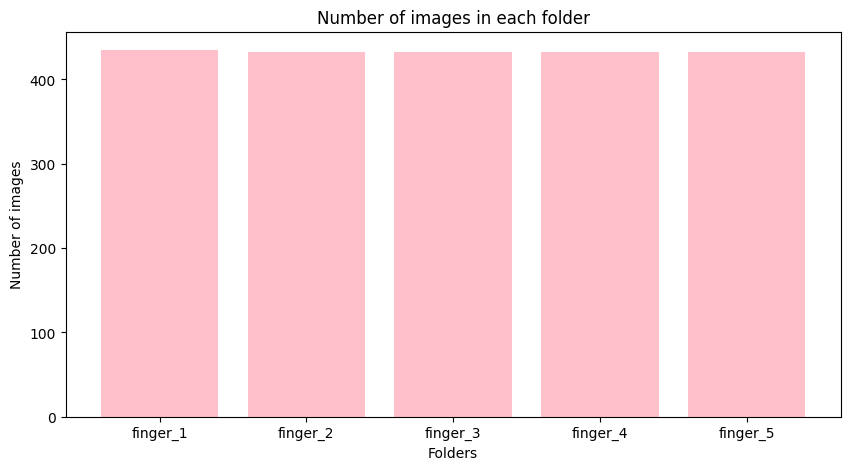

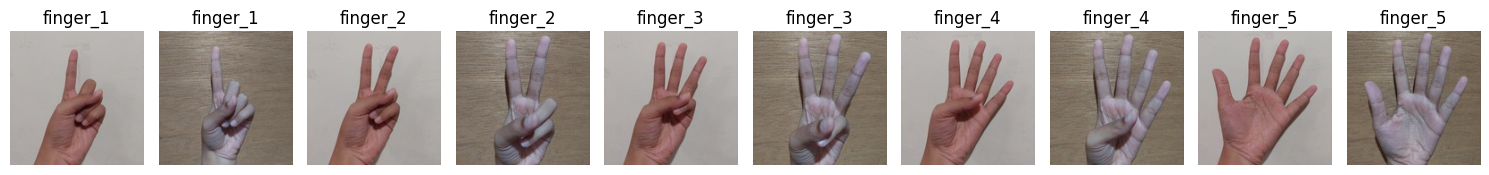

In [11]:
# Function untuk load dan resize gambar
def load_and_resize_images_from_folders(folders, target_size=(150, 150)):
    images = []
    labels = []
    folder_image_count = {}
    sample_images = {folder: [] for folder in folders}  # dictionary
    
    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        folder_image_count[folder_name] = 0
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                label = folder_name  # label dari nama folder
                labels.append(label)
                
                folder_image_count[folder_name] += 1
                
                if len(sample_images[folder_name]) < 2:  # folder_name sebagai kunci
                    sample_images[folder_name].append(img)
    
    return images, labels, folder_image_count, sample_images

# Folder paths
folder_paths = ['finger_1', 'finger_2', 'finger_3', 'finger_4', 'finger_5']

# load dan resize gambar
images, labels, folder_image_count, sample_images = load_and_resize_images_from_folders(folder_paths)

# cek nomor percobaan
print(f"Loaded {len(images)} images.")
print(f"Sample image shape: {images[0].shape}")
print(f"Sample label: {labels[0]}")

# Plot menampilkan gambar per folder
plt.figure(figsize=(10, 5))
plt.bar(folder_image_count.keys(), folder_image_count.values(), color='pink')
plt.xlabel('Folders')
plt.ylabel('Number of images')
plt.title('Number of images in each folder')
plt.show()

# menampilkan sample gambar
fig, axs = plt.subplots(1, len(folder_paths) * 2, figsize=(15, 5))
axs = axs.flatten()
for i, folder in enumerate(folder_paths):
    for j in range(2):
        index = i * 2 + j
        if j < len(sample_images[folder]):
            axs[index].imshow(cv2.cvtColor(sample_images[folder][j], cv2.COLOR_BGR2RGB))
            axs[index].set_title(f"{folder}")
        axs[index].axis('off')

plt.tight_layout()
plt.show()



## Data Preparation

### Data Augmentation

Kode di bawah ini mendefinisikan fungsi augment_image untuk melakukan augmentasi gambar dengan melakukan rotasi dan flipping. Gambar dirotasi sebesar ±30 derajat dan di-flip secara horizontal dan vertikal. Fungsi ini juga melakukan rotasi dan flip gabungan. Fungsi rotate_image menghitung pusat gambar, membuat matriks rotasi, dan memotong gambar agar sesuai dengan ukuran aslinya setelah rotasi. Fungsi flip_image melakukan flipping pada gambar. Setelah mendefinisikan fungsi augmentasi, kode ini mengaugmentasi sampel gambar dari setiap folder dan menampilkannya. Untuk setiap folder, kode menampilkan gambar asli bersama enam gambar augmentasi (dua rotasi, dua flip, dan dua kombinasi rotasi-flip) menggunakan subplots.

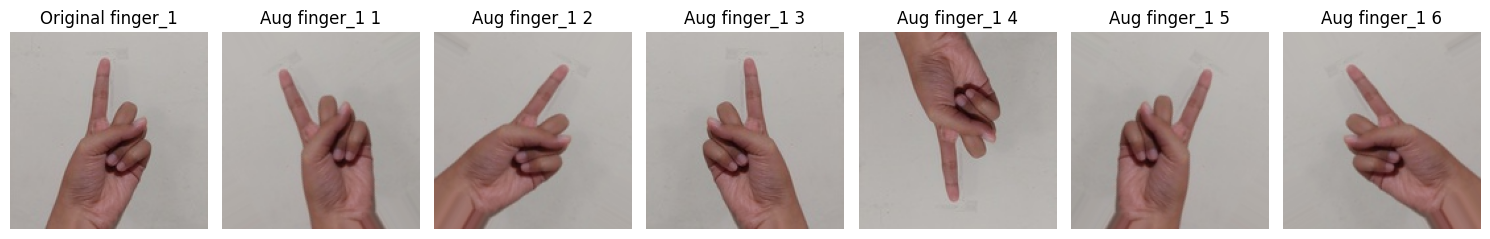

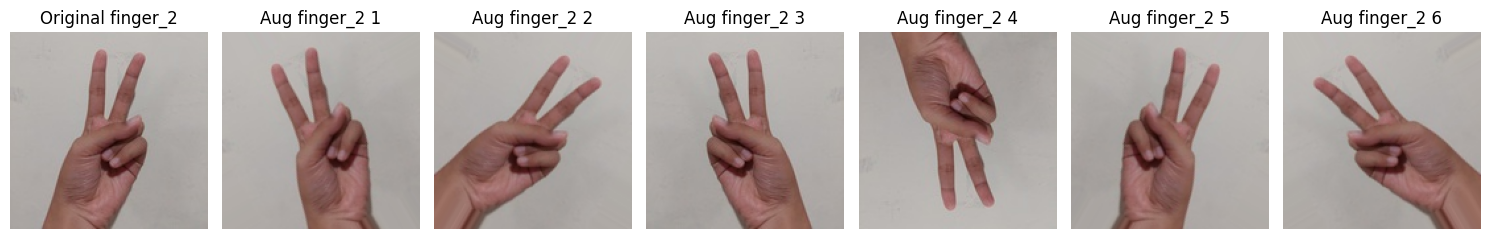

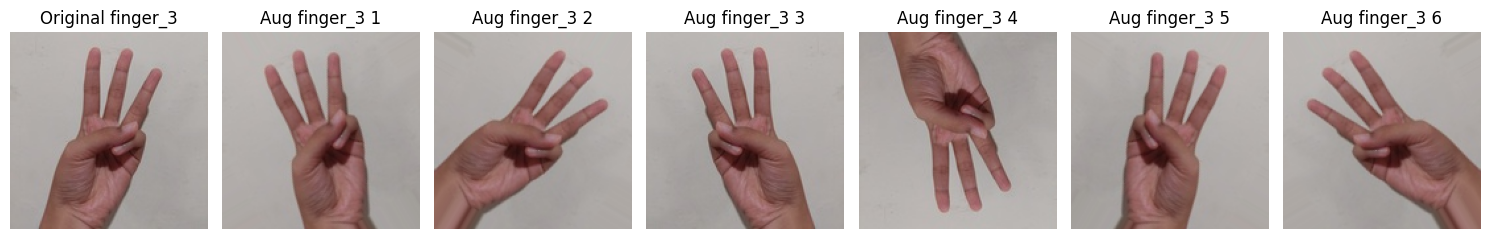

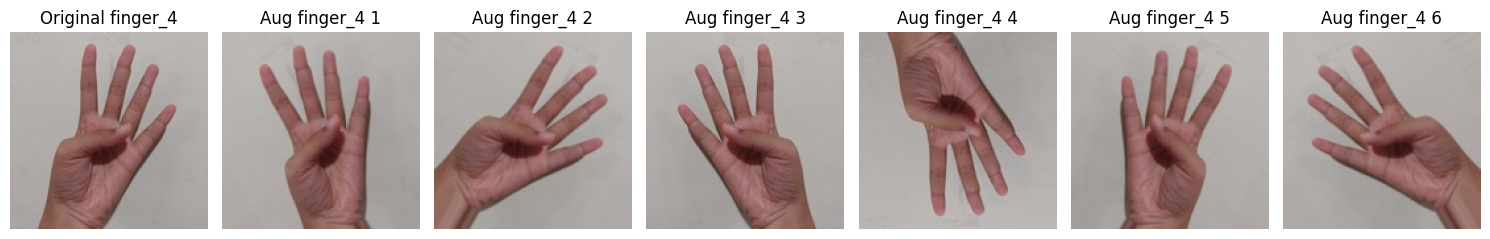

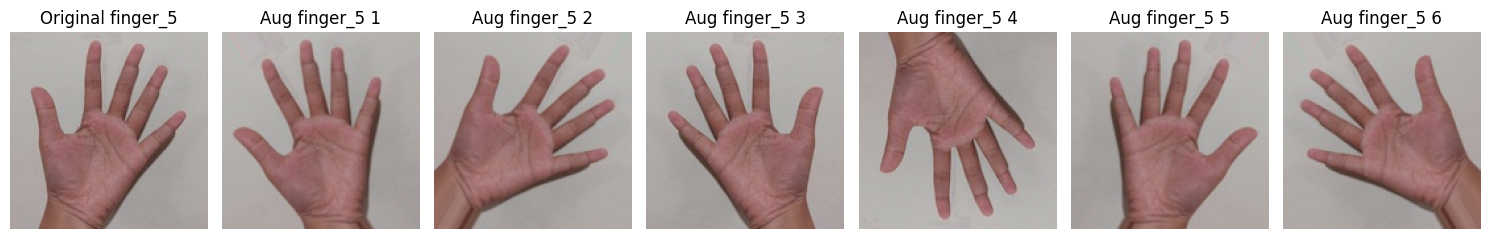

In [12]:
# Function untuk augmentasi gambar
def augment_image(image):
    height, width = image.shape[:2]
    augmented_images = []

    # Function untuk rotasi dan flip
    def rotate_image(image, angle):
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        abs_cos = abs(rot_mat[0,0])
        abs_sin = abs(rot_mat[0,1])
        
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)
        
        rot_mat[0, 2] += bound_w / 2 - image_center[0]
        rot_mat[1, 2] += bound_h / 2 - image_center[1]
        
        rotated_img = cv2.warpAffine(image, rot_mat, (bound_w, bound_h), borderMode=cv2.BORDER_REPLICATE)
        
        crop_x = (bound_w - width) // 2
        crop_y = (bound_h - height) // 2
        cropped_img = rotated_img[crop_y:crop_y + height, crop_x:crop_x + width]
        
        return cropped_img

    # Flipping function
    def flip_image(image, flip_code):
        return cv2.flip(image, flip_code)

    # melakukan augmentasi dan menambahkan ke list
    rotated1 = rotate_image(image, 30)
    augmented_images.append(rotated1)

    rotated2 = rotate_image(image, -30)
    augmented_images.append(rotated2)

    flipped_h = flip_image(image, 1)
    augmented_images.append(flipped_h)

    flipped_v = flip_image(image, 0)
    augmented_images.append(flipped_v)

    rotated_flipped1 = flip_image(rotated1, 1)
    augmented_images.append(rotated_flipped1)

    rotated_flipped2 = flip_image(rotated2, 1)
    augmented_images.append(rotated_flipped2)

    return augmented_images

# augmentasi untuk sample image per folder
augmented_samples = {folder: [] for folder in folder_paths}

for folder in folder_paths:
    for sample_image in sample_images[folder]:
        augmented_samples[folder].extend(augment_image(sample_image))

# Plot original dan augmented images
for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 7, 1)
    plt.imshow(cv2.cvtColor(sample_images[folder][0], cv2.COLOR_BGR2RGB))
    plt.title(f'Original {folder}')
    plt.axis('off')

    for i, aug_img in enumerate(augmented_samples[folder][:6]):
        plt.subplot(1, 7, i+2)
        plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Aug {folder} {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Preprocessing

#### GRAYSCALE

Kode tersebut mengonversi gambar augmentasi menjadi grayscale dan menampilkannya. Pertama, kode membuat kamus gray_images yang menyimpan gambar augmentasi dalam format grayscale untuk setiap folder. Konversi ini dilakukan dengan menggunakan fungsi cv2.cvtColor dari OpenCV dengan parameter cv2.COLOR_BGR2GRAY. Selanjutnya, untuk setiap folder, kode menampilkan enam gambar grayscale pertama dari folder tersebut menggunakan subplots. Setiap subplot menampilkan satu gambar grayscale dengan judul yang mencantumkan nama folder dan nomor urutan gambar grayscale tersebut, dan axis subplot dinonaktifkan untuk tampilan yang lebih bersih.

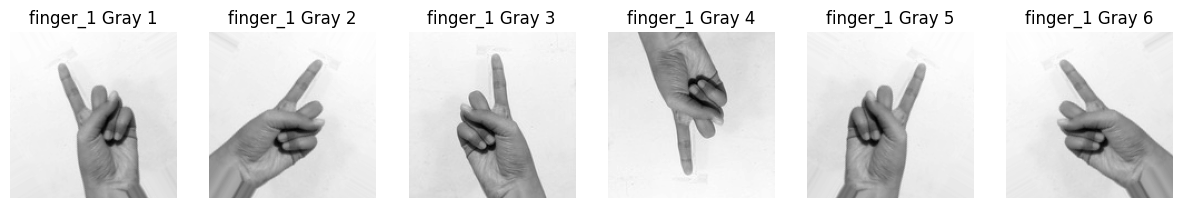

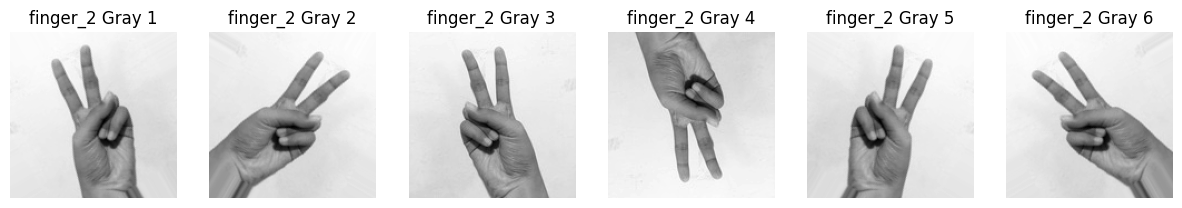

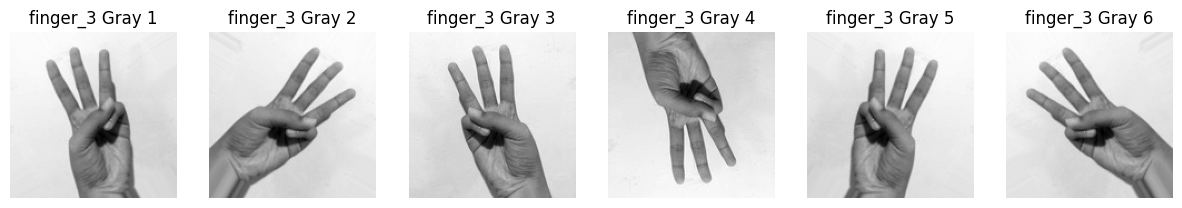

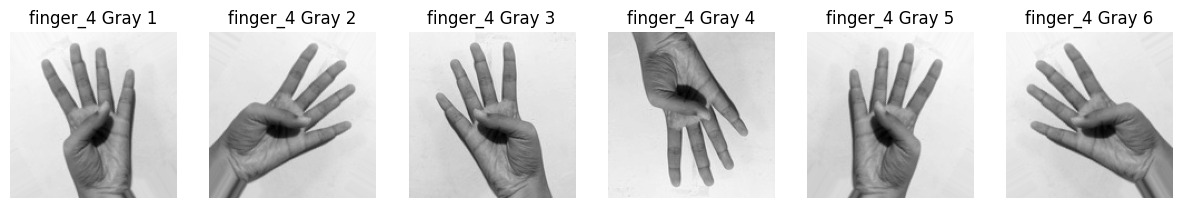

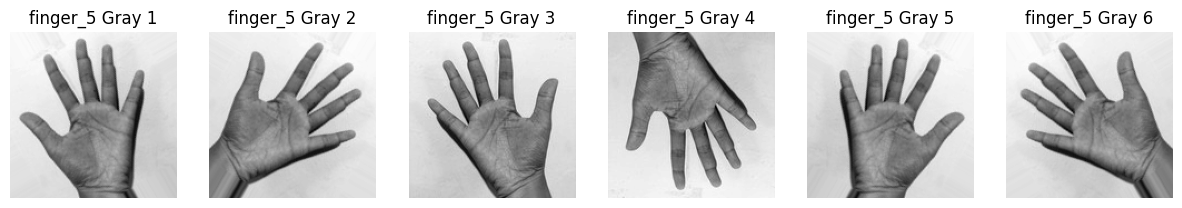

In [13]:
# Convert images ke grayscale
gray_images = {folder: [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in augmented_samples[folder]] for folder in folder_paths}

# menampilkan gambar sample grayscale
for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(gray_images[folder][i], cmap='gray')
        plt.title(f'{folder} Gray {i+1}')
        plt.axis('off')
    plt.show()

#### NORMALISASI

Kode di bawah menormalkan gambar grayscale dan menampilkannya. Pertama, kode membuat kamus normalized_images yang menyimpan gambar grayscale yang telah dinormalisasi untuk setiap folder. Normalisasi dilakukan dengan membagi nilai piksel setiap gambar dengan 255.0, sehingga nilai piksel berada dalam rentang 0 hingga 1. Selanjutnya, untuk setiap folder, kode menampilkan enam gambar grayscale pertama yang telah dinormalisasi menggunakan subplots. Setiap subplot menampilkan satu gambar yang dinormalisasi dengan judul yang mencantumkan nama folder dan nomor urutan gambar yang dinormalisasi tersebut, serta axis subplot dinonaktifkan untuk tampilan yang lebih bersih.

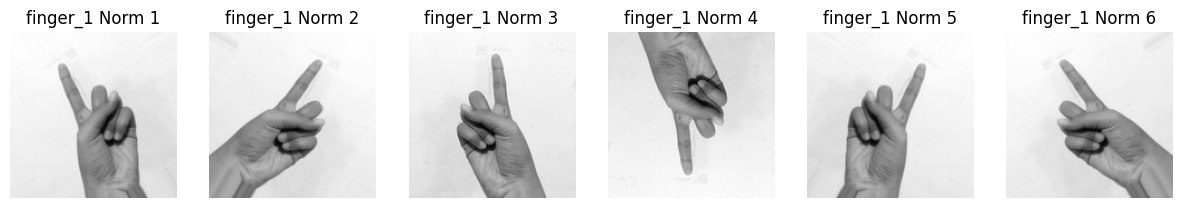

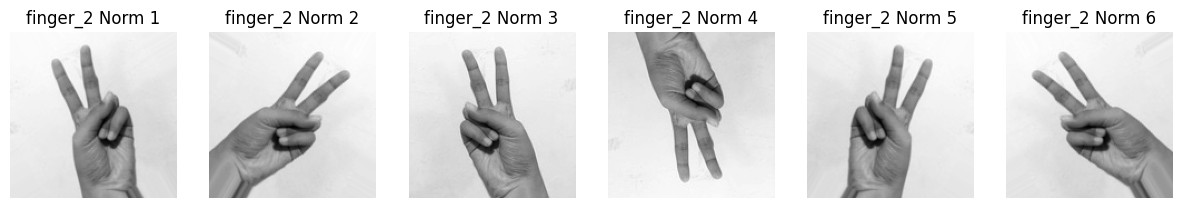

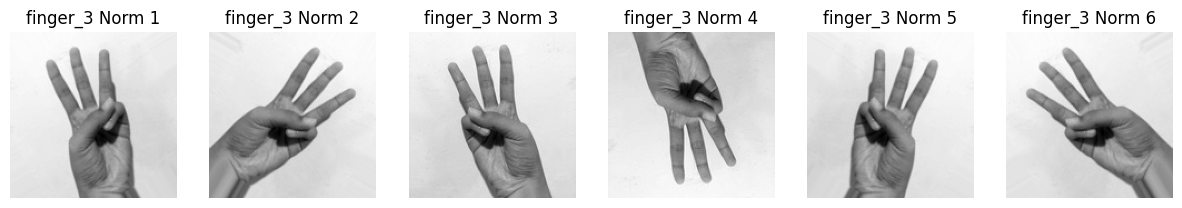

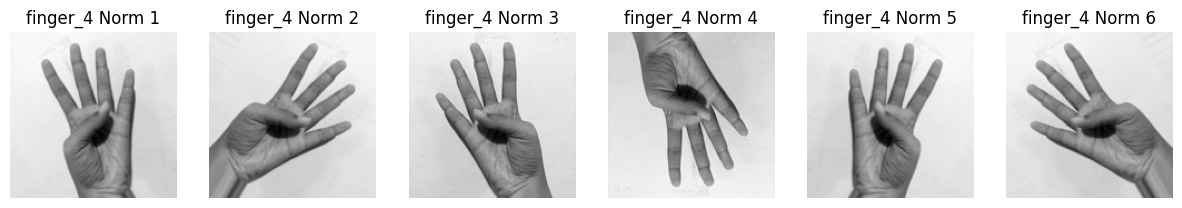

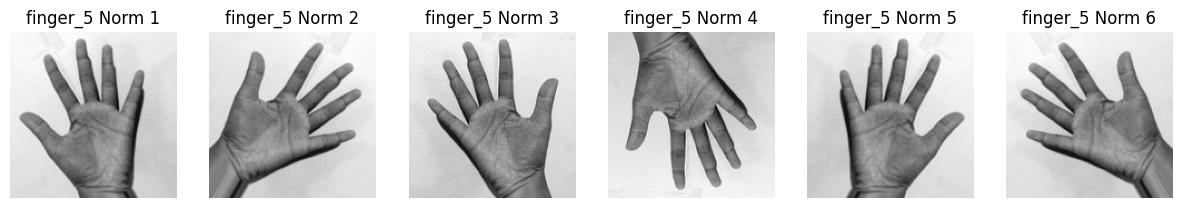

In [14]:
# Normalize images
normalized_images = {folder: [img / 255.0 for img in gray_images[folder]] for folder in folder_paths}

# menampilkan gambar sample normalisasi 
for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(normalized_images[folder][i], cmap='gray')
        plt.title(f'{folder} Norm {i+1}')
        plt.axis('off')
    plt.show()

#### DETEKSI TEPI

Kode di bawah mendeteksi tepi gambar yang telah dinormalisasi dan menampilkannya. Pertama, kode membuat kamus edge_images yang menyimpan gambar hasil deteksi tepi untuk setiap folder. Deteksi tepi dilakukan menggunakan algoritma Canny dari OpenCV (cv2.Canny), di mana gambar dinormalisasi dikalikan dengan 255 dan dikonversi kembali ke tipe uint8 sebelum diterapkan deteksi tepi dengan ambang batas 100 dan 200. Selanjutnya, untuk setiap folder, kode menampilkan enam gambar hasil deteksi tepi pertama menggunakan subplots. Setiap subplot menampilkan satu gambar dengan judul yang mencantumkan nama folder dan nomor urutan gambar hasil deteksi tepi tersebut, serta axis subplot dinonaktifkan untuk tampilan yang lebih bersih.

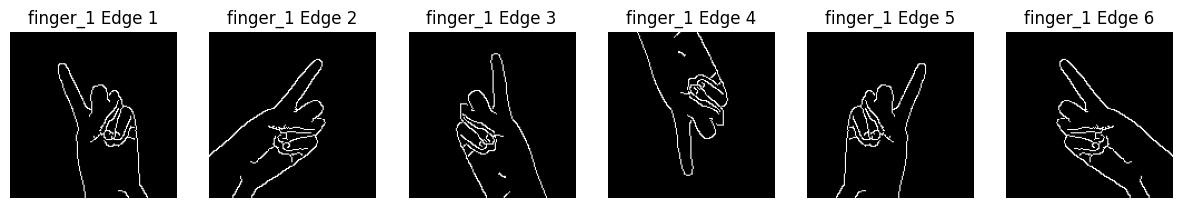

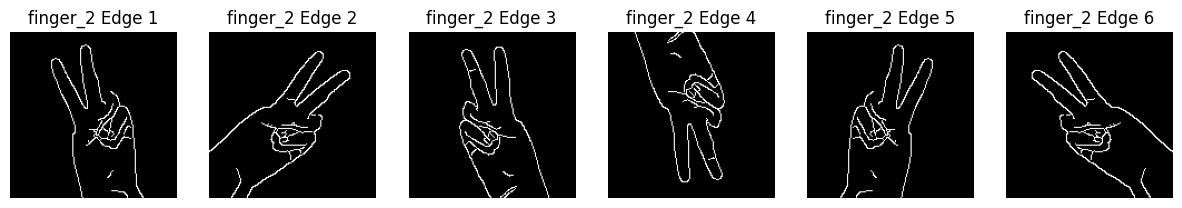

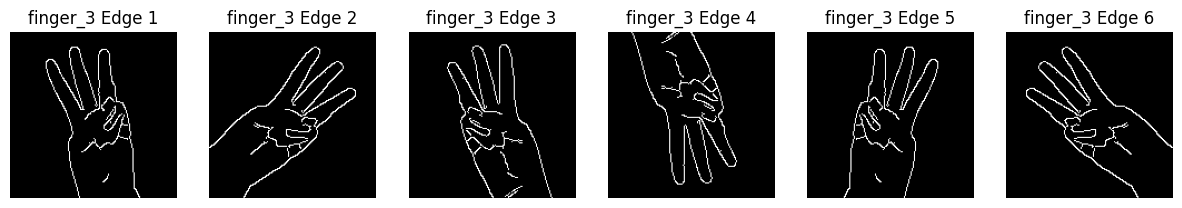

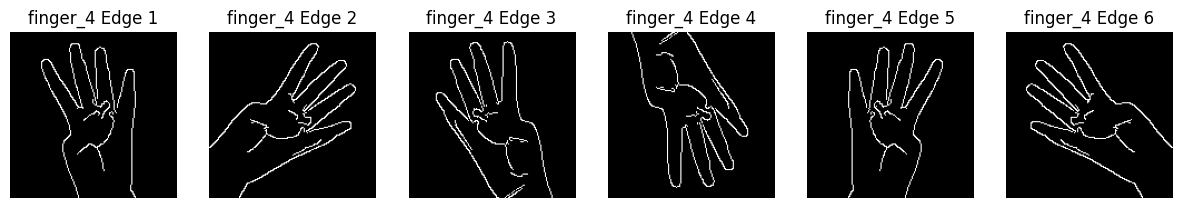

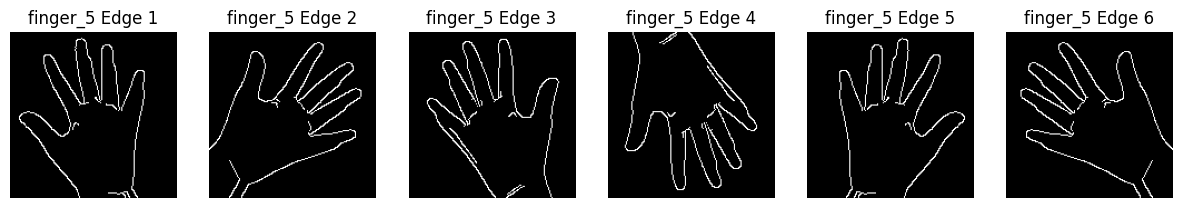

In [15]:
# deteksi tepi
edge_images = {folder: [cv2.Canny((img * 255).astype(np.uint8), 100, 200) for img in normalized_images[folder]] for folder in folder_paths}

# menampilkan gambar sample deteksi tepi
for folder in folder_paths:
    plt.figure(figsize=(15, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(edge_images[folder][i], cmap='gray')
        plt.title(f'{folder} Edge {i+1}')
        plt.axis('off')
    plt.show()


### Feature Extraction

Kode di bawah melakukan ekstraksi fitur tekstur dari gambar menggunakan matriks co-occurrence level gray (GLCM) pada empat sudut (0°, 45°, 90°, dan 135°). Pertama, beberapa fungsi didefinisikan untuk menghitung GLCM dan fitur tekstur seperti energi, homogenitas, entropi, kontras, dissimilarity, ASM, dan korelasi. Kemudian, kode mengekstraksi GLCM dan fitur tekstur untuk setiap gambar di folder yang diberikan. Hasil ekstraksi fitur disimpan dalam list hasil_ekstraksi. Fungsi save_frame digunakan untuk menyimpan hasil ekstraksi fitur ke dalam DataFrame dengan kolom yang sesuai. Akhirnya, DataFrame dibuat dan ditampilkan tanpa menyertakan jalur gambar.

In [16]:
# Fungsi GLCM untuk sudut 0 derajat
def derajat0(img):
    max_val = np.max(img)
    img_tmp = np.zeros([max_val + 1, max_val + 1])
    for i in range(len(img)):
        for j in range(len(img[i]) - 1):
            img_tmp[img[i, j], img[i, j + 1]] += 1

    data = img_tmp + np.transpose(img_tmp)
    tmp = np.sum(data)

    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

# Fungsi GLCM untuk sudut 45 derajat
def derajat45(img):
    max_val = np.max(img)
    img_tmp = np.zeros([max_val + 1, max_val + 1])
    for i in range(len(img) - 1):
        for j in range(len(img[i]) - 1):
            img_tmp[img[i + 1, j], img[i, j + 1]] += 1

    data = img_tmp + np.transpose(img_tmp)
    tmp = np.sum(data)

    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

# Fungsi GLCM untuk sudut 90 derajat
def derajat90(img):
    max_val = np.max(img)
    img_tmp = np.zeros([max_val + 1, max_val + 1])
    for i in range(len(img) - 1):
        for j in range(len(img[i])):
            img_tmp[img[i + 1, j], img[i, j]] += 1

    data = img_tmp + np.transpose(img_tmp)
    tmp = np.sum(data)

    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

# Fungsi GLCM untuk sudut 135 derajat
def derajat135(img):
    max_val = np.max(img)
    img_tmp = np.zeros([max_val + 1, max_val + 1])
    for i in range(len(img) - 1):
        for j in range(len(img[i]) - 1):
            img_tmp[img[i, j], img[i + 1, j + 1]] += 1

    data = img_tmp + np.transpose(img_tmp)
    tmp = np.sum(data)

    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

# Fungsi fitur Contrast
def contrast(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += data[i, j] * pow(i - j, 2)
    return simpan

# Fungsi fitur Dissimilarity
def dissimilarity(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += data[i, j] * abs(i - j)
    return simpan

# Fungsi fitur Homogeneity
def homogeneity(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += data[i, j] / (1 + abs(i - j))
    return simpan

# Fungsi fitur Entropy
def entropy(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            if data[i, j] > 0:
                simpan += - (data[i, j] * math.log(data[i, j]))
    return simpan

# Fungsi fitur ASM (Angular Second Moment)
def ASM(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += pow(data[i, j], 2)
    return simpan

# Fungsi fitur Energy
def energy(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += pow(data[i, j], 2)
    return simpan

# Fungsi fitur Correlation
def correlation(data, mI, mJ, tI, tJ):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += ((i - mI) * (j - mJ) * data[i, j]) / (tI * tJ)
    return simpan

# Fungsi meanI
def meanI(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += i * data[i, j]
    return simpan

# Fungsi meanJ
def meanJ(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += j * data[i, j]
    return simpan

# Fungsi taoI
def taoI(data, mI):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += pow((i - mI), 2) * data[i, j]
    simpan = math.sqrt(simpan)
    return simpan

# Fungsi taoJ
def taoJ(data, mJ):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += pow((j - mJ), 2) * data[i, j]
    simpan = math.sqrt(simpan)
    return simpan

# Fungsi untuk menyimpan hasil ekstraksi fitur ke dalam DataFrame
def save_frame(result):
    frame = []
    for i in tqdm(range(len(result)), desc="Extracting Features", unit=" images", unit_scale=True):
        save = []
        for j in result[i]:
            en = energy(j)
            save.append(en)

            hm = homogeneity(j)
            save.append(hm)

            ent = entropy(j)
            save.append(ent)

            con = contrast(j)
            save.append(con)

            dis = dissimilarity(j)
            save.append(dis)

            asm = ASM(j)
            save.append(asm)
            mI = meanI(j)
            mJ = meanJ(j)
            tI = taoI(j, mI)
            tJ = taoJ(j, mJ)

            cor = correlation(j, mI, mJ, tI, tJ)
            save.append(cor)
        frame.append(save)
    return frame

# Mendefinisikan list untuk menyimpan hasil ekstraksi fitur
hasil_ekstraksi = []
filenames = []

# Melakukan ekstraksi fitur untuk setiap gambar di setiap folder
for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Ekstraksi fitur dengan GLCM untuk setiap sudut
        glcm_0 = derajat0(img)
        glcm_45 = derajat45(img)
        glcm_90 = derajat90(img)
        glcm_135 = derajat135(img)

        # Menyimpan hasil ekstraksi fitur dalam sebuah list
        hasil_ekstraksi.append([glcm_0, glcm_45, glcm_90, glcm_135])
        filenames.append(filename)

# Membuat header untuk DataFrame
header = ['energy_0', 'homogeneity_0', 'entropy_0', 'contrast_0', 'dissimilarity_0', 'ASM_0', 'correlation_0',
          'energy_45', 'homogeneity_45', 'entropy_45', 'contrast_45', 'dissimilarity_45', 'ASM_45', 'correlation_45',
          'energy_90', 'homogeneity_90', 'entropy_90', 'contrast_90', 'dissimilarity_90', 'ASM_90', 'correlation_90',
          'energy_135', 'homogeneity_135', 'entropy_135', 'contrast_135', 'dissimilarity_135', 'ASM_135', 'correlation_135']

# Simpan hasil ekstraksi fitur ke dalam DataFrame tanpa kolom path
df = pd.DataFrame(save_frame(hasil_ekstraksi), columns=header)

# Tampilkan DataFrame
df


Extracting Features: 100%|██████████| 2.16k/2.16k [52:12<00:00, 1.45s/ images]  


energy_0  homogeneity_0  entropy_0   contrast_0  dissimilarity_0  \
0     0.010300       0.636081   5.834831    57.225056         2.547740   
1     0.002077       0.364218   6.953525    55.560179         4.195973   
2     0.001854       0.438267   6.847298    32.363356         2.975168   
3     0.002893       0.530414   6.749682    84.812036         3.151991   
4     0.000201       0.178486   9.125578  1734.462416        26.532841   
...        ...            ...        ...          ...              ...   
2159  0.000279       0.181608   8.997090   401.758810        14.189405   
2160  0.000326       0.277876   8.710933   303.464702         9.989226   
2161  0.000732       0.377511   7.989599   230.776964         7.130060   
2162  0.000734       0.355994   7.997796   323.769881         8.362500   
2163  0.000856       0.387455   7.901383   209.314881         6.793333   

         ASM_0  correlation_0  energy_45  homogeneity_45  entropy_45  ...  \
0     0.010300       0.973248   0.007675        0.574869    6.043832  ...   
1     0.002077       0.915548   0.001191        0.264522    7.390195  ...   
2     0.001854       0.960621   0.001524        0.395094    7.035543  ...   
3     0.002893       0.970755   0.002208        0.465373    6.961709  ...   
4     0.000201       0.786529   0.000244        0.205473    8.998163  ...   
...        ...            ...        ...             ...         ...  ...   
2159  0.000279       0.912526   0.000234        0.156432    9.140445  ...   
2160  0.000326       0.955712   0.000227        0.220075    8.979755  ...   
2161  0.000732       0.941340   0.000553        0.316662    8.214564  ...   
2162  0.000734       0.922597   0.000597        0.305742    8.205033  ...   
2163  0.000856       0.936062   0.000645        0.325551    8.127409  ...   

      dissimilarity_90    ASM_90  correlation_90  energy_135  homogeneity_135  \
0             2.201253  0.009174        0.986623    0.007755         0.566051   
1             5.796107  0.001233        0.895030    0.001122         0.249973   
2             3.179553  0.001733        0.953650    0.001463         0.382738   
3             2.398568  0.002695        0.989424    0.002217         0.465190   
4            21.221924  0.000222        0.860039    0.000203         0.185368   
...                ...       ...             ...         ...              ...   
2159         12.904080  0.000304        0.923348    0.000210         0.160104   
2160          9.647503  0.000343        0.955494    0.000221         0.213404   
2161          5.390628  0.000708        0.970049    0.000535         0.313084   
2162          5.535428  0.000850        0.965482    0.000594         0.308633   
2163          4.995605  0.000944        0.965126    0.000665         0.328633   

      entropy_135  contrast_135  dissimilarity_135   ASM_135  correlation_135  
0        6.082641     96.903293           3.605693  0.007755         0.954780  
1        7.468392    118.360029           7.151885  0.001122         0.819909  
2        7.108021     69.387685           4.229449  0.001463         0.915488  
3        6.978532     98.043692           3.762083  0.002217         0.966174  
4        9.138810   2381.550245          28.313635  0.000203         0.706895  
...           ...           ...                ...       ...              ...  
2159     9.142848    626.706675          17.757011  0.000210         0.862615  
2160     9.014769    637.535355          15.194751  0.000221         0.907086  
2161     8.219325    331.961589           8.823406  0.000535         0.914586  
2162     8.168067    363.458473           9.167006  0.000594         0.912231  
2163     8.104009    308.576163           8.424796  0.000665         0.904523  

[2164 rows x 28 columns]

### Features Selection

#### Correlation Matrix

Kode di bawah menghitung matriks korelasi untuk fitur-fitur dalam DataFrame df dan menampilkan heatmap korelasi menggunakan Seaborn. Matriks korelasi (corr_matrix) menunjukkan hubungan antara setiap pasangan fitur. Heatmap memvisualisasikan nilai korelasi ini, dengan anotasi nilai korelasi pada setiap sel. Selanjutnya, kode mengidentifikasi fitur-fitur yang memiliki korelasi tinggi (lebih dari 0.9) dengan menggunakan bagian atas matriks korelasi (upper). Fitur-fitur dengan korelasi tinggi kemudian dihapus dari DataFrame (df_reduced_corr) untuk mengurangi multikolinearitas. Akhirnya, daftar fitur yang dihapus ditampilkan.

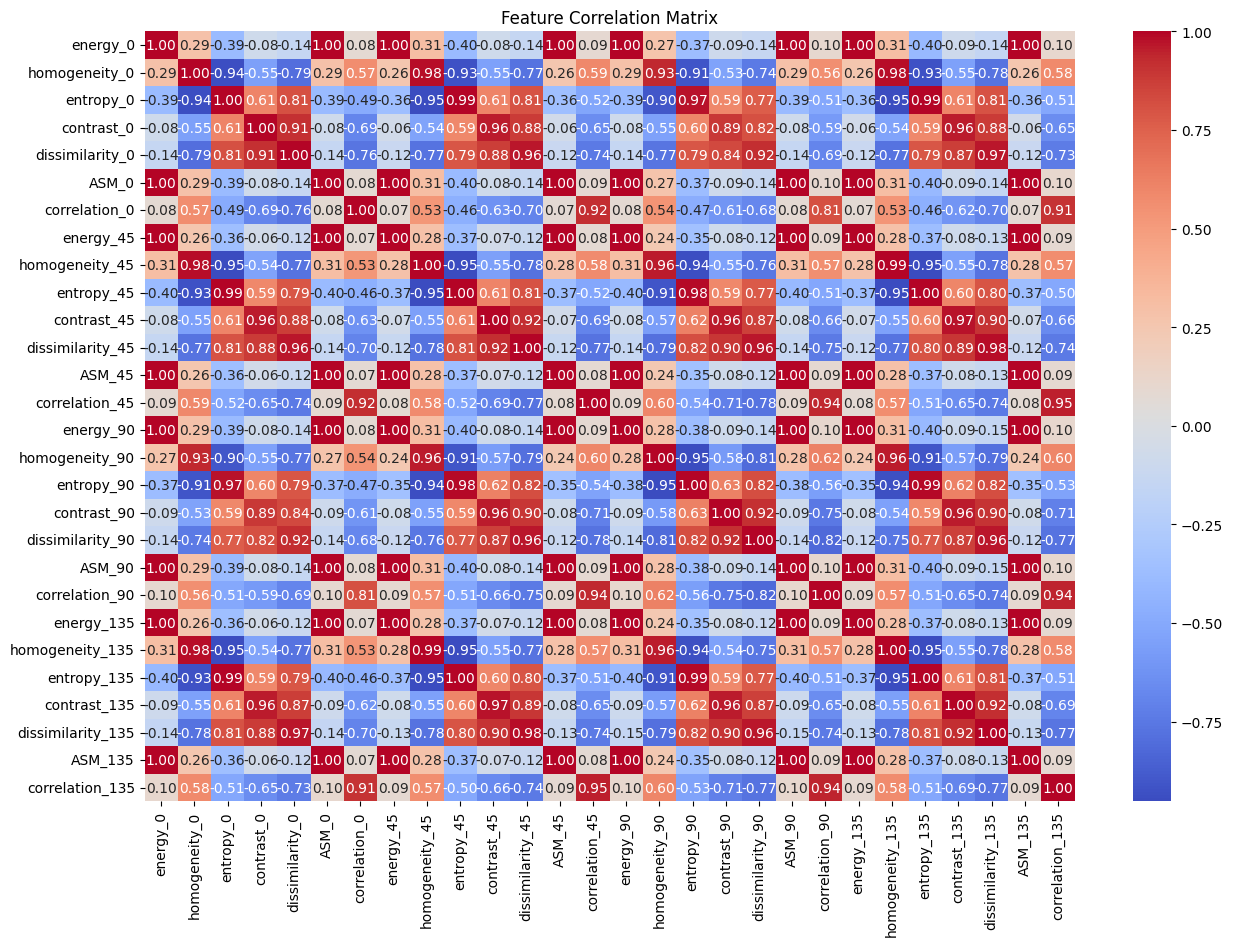

Dropped features due to high correlation: ['dissimilarity_0', 'ASM_0', 'energy_45', 'homogeneity_45', 'entropy_45', 'contrast_45', 'dissimilarity_45', 'ASM_45', 'correlation_45', 'energy_90', 'homogeneity_90', 'entropy_90', 'contrast_90', 'dissimilarity_90', 'ASM_90', 'correlation_90', 'energy_135', 'homogeneity_135', 'entropy_135', 'contrast_135', 'dissimilarity_135', 'ASM_135', 'correlation_135']


In [17]:
# menghitung korelasi matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# memilih fitur yang memiliki korelasi yang tinggi
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# mengecek fitur yang memiliki korelasi yang tinggi di atas 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# menampilkan fitur
df_reduced_corr = df.drop(to_drop, axis=1)
print(f"Dropped features due to high correlation: {to_drop}")


#### PCA

Kode di bawah ini melakukan standarisasi fitur-fitur dalam DataFrame df menggunakan StandardScaler untuk memastikan setiap fitur memiliki mean nol dan variansi satu. Kemudian, Principal Component Analysis (PCA) diterapkan pada fitur-fitur yang telah distandarisasi untuk mereduksi dimensi data, dengan mempertahankan 95% dari total variansi. Hasil PCA berupa principal components disimpan dalam DataFrame df_pca, dengan kolom yang dinamai sesuai urutan principal components (PC1, PC2, dst). Kode juga mencetak variansi yang dijelaskan oleh setiap principal component dan total variansi yang dijelaskan. Terakhir, DataFrame df_pca yang berisi principal components ditampilkan.

In [18]:
# standarisasi
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# menjalankan PCA
pca = PCA(n_components=0.95)  # menggunakan 95% dari variansi
principal_components = pca.fit_transform(scaled_features)

# membuat DataFrame
df_pca = pd.DataFrame(data=principal_components, 
                      columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# menampilkan jumlah dari jenis pca
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each principal component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")

# Tampilkan DataFrame
df_pca.head()


Explained variance by each principal component: [0.56984313 0.27198726 0.08181409 0.04523447]
Total explained variance: 0.9688789474215836


PC1       PC2       PC3       PC4
0  -5.073715 -0.519233  1.731069  0.182980
1  -0.096128 -0.383103  0.112059 -2.422606
2  -2.368410 -1.084308  0.078305 -0.855698
3  -3.300297 -1.180394  0.399070  0.157680
4  10.640932  4.154297  4.248420  3.115866

### Splitting Data

Code di bawah ini melakukan beberapa langkah untuk mempersiapkan data untuk pembelajaran mesin. Pertama, itu iterasi melalui setiap folder di folder_paths dan setiap file di dalamnya. Kemudian, label dari setiap folder disimpan dalam list labels. Setelah itu, list labels diubah menjadi DataFrame df_labels dengan kolom bernama 'label'. Selanjutnya, label-label tersebut diubah menjadi kode numerik menggunakan astype('category').cat.codes dan disimpan kembali ke kolom 'label'. Selanjutnya, data fitur (X) dan label (y) dipisahkan dari DataFrame gabungan menggunakan drop dan kemudian dibagi menjadi data latih dan data uji dengan rasio 80:20 menggunakan train_test_split. Akhirnya, dimensi dari data latih dan data uji dicetak.

Pada tahap ini, Anda diminta untuk membagi data menjadi data training dan data testing. Anda dapat menggunakan perbandingan 80:20 atau 70:30, atau perbandingan lain yang Anda anggap perlu. Jelaskan alasan Anda menggunakan perbandingan tersebut.
>Data dibagi menjadi data training dan data testing dengan perbandingan 80:20. Pemilihan perbandingan ini merupakan praktik yang umum digunakan dalam banyak kasus pemodelan machine learning karena memberikan keseimbangan yang baik antara memaksimalkan jumlah data training untuk meningkatkan kinerja model, dan menyediakan cukup data testing untuk mengevaluasi performa model secara akurat. Perbandingan 80:20 juga merupakan standar yang diakui dan memudahkan perbandingan dengan hasil-hasil lain dalam literatur atau penelitian terkait, serta sesuai untuk digunakan ketika jumlah data cukup besar dan tidak ada alasan khusus untuk menggunakan perbandingan lain.

In [19]:
labels = []

for folder in folder_paths:
    for filename in os.listdir(folder):
        labels.append(folder)

# Convert the label ke DataFrame
df_labels = pd.DataFrame(labels, columns=['label'])

# menggabungkan label dan fitur dari DataFrame
df_combined = pd.concat([df_labels, df], axis=1)

# cek apabila label bukan numerik
df_combined['label'] = df_combined['label'].astype('category').cat.codes

# Splitting data ke fitur (X) dan label (y)
X = df_combined.drop('label', axis=1)
y = df_combined['label']

# Split data ke training 80% dan testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# cek hasil dari split dataset
print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training data shape: X_train: (1731, 28), y_train: (1731,)
Testing data shape: X_test: (433, 28), y_test: (433,)


### Normalization

Pada tahap ini, Anda diminta untuk melakukan normalisasi data. Anda dapat menggunakan teknik normalisasi standarization atau min-max normalization. Jelaskan alasan Anda menggunakan teknik tersebut dan berikan alasan mengapa normalisasi diperlukan.
>normalisasi data dilakukan menggunakan teknik standardisasi (standardization) dengan menggunakan StandardScaler dari library scikit-learn. Teknik ini dipilih karena memberikan keuntungan dalam menjaga fitur-fitur yang memiliki varians tinggi agar tidak mendominasi fitur-fitur dengan varians rendah, serta menyesuaikan skala fitur sehingga memiliki rata-rata nol dan standar deviasi satu. Normalisasi diperlukan untuk menyamakan skala fitur yang berbeda sehingga algoritma machine learning yang digunakan dapat bekerja dengan optimal dan tidak terlalu berfokus pada fitur dengan skala yang jauh lebih besar dibandingkan fitur lainnya.

In [20]:
# normalisasi data  
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Code di bawah melakukan normalisasi data fitur dengan menggunakan StandardScaler dari scikit-learn. Pertama, sebuah objek StandardScaler dibuat. Kemudian, metode fit_transform dipanggil pada data latih (X_train) untuk menghitung mean dan standar deviasi dari setiap fitur, dan kemudian melakukan normalisasi data latih. Data uji (X_test) kemudian di-normalisasi menggunakan informasi yang sama yang digunakan untuk data latih dengan memanggil transform pada objek scaler yang sama. Hal ini memastikan bahwa skala data uji sama dengan skala data latih yang telah dinormalisasi. Sebagai hasilnya, kedua data latih dan data uji sekarang telah dinormalisasi dan siap untuk digunakan dalam pembelajaran mesin.

## Modeling

#### KNN

Code di bawah ini mengimplementasikan algoritma K-Nearest Neighbors (KNN) untuk klasifikasi. Pertama, model KNN diinisialisasi dengan jumlah tetangga (n_neighbors) yang diatur ke 5. Kemudian, model tersebut dilatih dengan memanggil metode fit pada data latih yang telah dinormalisasi. Setelah model dilatih, dilakukan prediksi pada data uji dengan memanggil metode predict pada data uji yang juga telah dinormalisasi. Selanjutnya, akurasi dari model KNN dihitung dengan membandingkan prediksi yang dihasilkan dengan label sebenarnya dari data uji menggunakan fungsi accuracy_score. Akurasi yang dihitung kemudian dicetak.

In [21]:
# inisialisasi model knn
knn = KNeighborsClassifier(n_neighbors=5)

# train model
knn.fit(X_train_scaled, y_train)

# Predict ke test set
y_pred_knn = knn.predict(X_test_scaled)

# mencari akurasi
knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {knn_accuracy}")

KNN Accuracy: 0.11778290993071594


#### SVC

Code di bawah ini mengimplementasikan algoritma Support Vector Machine (SVM) untuk klasifikasi dengan kernel linear. Pertama, model SVM diinisialisasi dengan parameter kernel yang diatur menjadi 'linear'. Selanjutnya, model tersebut dilatih dengan memanggil metode fit pada data latih yang telah dinormalisasi. Setelah model dilatih, dilakukan prediksi pada data uji dengan memanggil metode predict pada data uji yang juga telah dinormalisasi. Akurasi dari model SVM dihitung dengan membandingkan prediksi yang dihasilkan dengan label sebenarnya dari data uji menggunakan fungsi accuracy_score. Akurasi yang dihitung kemudian dicetak.

In [22]:
# inisialisasi model svm
svm = SVC(kernel='linear')

# Train model
svm.fit(X_train_scaled, y_train)

# Predict ke test set
y_pred_svm = svm.predict(X_test_scaled)

# mencari akurasi
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.22401847575057737


#### RANDOM FOREST

Code di bawah ini mengimplementasikan algoritma Random Forest untuk klasifikasi. Pertama, model Random Forest diinisialisasi dengan 100 pohon keputusan (n_estimators=100) dan nilai random_state yang ditetapkan ke 42 untuk memastikan reproduktibilitas. Kemudian, model tersebut dilatih dengan memanggil metode fit pada data latih yang telah dinormalisasi. Setelah model dilatih, dilakukan prediksi pada data uji dengan memanggil metode predict pada data uji yang juga telah dinormalisasi. Akurasi dari model Random Forest dihitung dengan membandingkan prediksi yang dihasilkan dengan label sebenarnya dari data uji menggunakan fungsi accuracy_score. Akurasi yang dihitung kemudian dicetak.

In [23]:
# inisialisasi model random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
rf.fit(X_train_scaled, y_train)

# Predict ke test set
y_pred_rf = rf.predict(X_test_scaled)

# mencari akurasi
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.14087759815242495


## Evaluation

Code di bawah ini melakukan evaluasi performa dari model KNN, SVM, dan Random Forest yang telah dilatih sebelumnya. Untuk setiap model, dilakukan perhitungan matriks kebingungan (confusion matrix), akurasi, presisi, recall, dan f1-score menggunakan fungsi-fungsi dari modul scikit-learn. Hasil evaluasi ini disimpan dalam sebuah DataFrame yang kemudian dicetak. 

In [24]:
# KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Create DataFrame
evaluation_results = pd.DataFrame({
    'Model': ['K-Nearest Neighbors', 'Support Vector Machine', 'Random Forest'],
    'Accuracy': [accuracy_knn, accuracy_svm, accuracy_rf],
    'Precision': [precision_knn, precision_svm, precision_rf],
    'Recall': [recall_knn, recall_svm, recall_rf],
    'f1-score': [f1_knn, f1_svm, f1_rf]
})

# menampilkan DataFrame
print("Tabel Hasil Evaluasi:")
evaluation_results


Tabel Hasil Evaluasi:


Model  Accuracy  Precision    Recall  f1-score
0     K-Nearest Neighbors  0.117783   0.112174  0.117783  0.112777
1  Support Vector Machine  0.224018   0.191598  0.224018  0.191519
2           Random Forest  0.140878   0.147756  0.140878  0.143928

Code di bawah ini menghasilkan tiga heatmap yang menunjukkan matriks kebingungan (confusion matrix) dari masing-masing model klasifikasi (KNN, SVM, dan Random Forest). Setiap heatmap menampilkan nilai-nilai dalam matriks kebingungan dengan anotasi teks dan menggunakan skala warna yang berbeda untuk membedakan nilai-nilai yang berbeda. Axis x (horizontal) pada heatmap menunjukkan kelas yang diprediksi oleh model, sedangkan axis y (vertikal) menunjukkan kelas sebenarnya dari data uji. Ini membantu dalam memvisualisasikan seberapa baik model mengklasifikasikan setiap kelas dan mengidentifikasi di mana model cenderung membuat kesalahan. Ukuran heatmap dan layout keseluruhan diatur agar sesuai dan mudah dibaca.

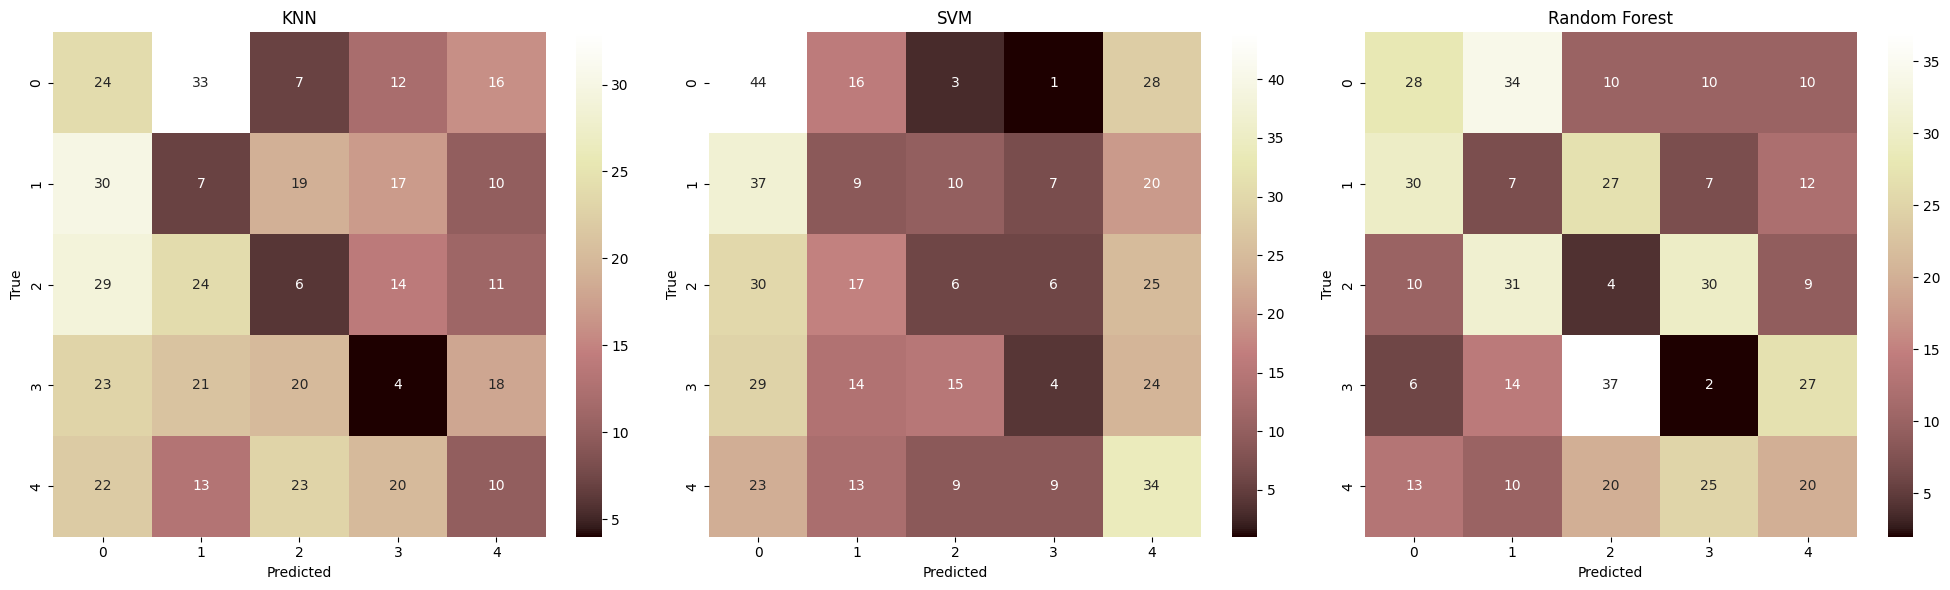

In [27]:
# Plot confusion matriks sisi demi sisi
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cm_knn, annot=True, fmt='g', ax=axes[0], cmap='pink')
axes[0].set_title('KNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_svm, annot=True, fmt='g', ax=axes[1], cmap='pink')
axes[1].set_title('SVM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(cm_rf, annot=True, fmt='g', ax=axes[2], cmap='pink')
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()